In [1]:
import math
import copy
import xgboost as xgb
import lasio
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVR
from sklearn.metrics import r2_score

from fastai.tabular import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline

In [2]:
well_6_composite_las = lasio.read("../data/PETROPHYSICS/WELL-6_COMPOSITE.LAS")
# well_6_composite_las.header

Header section Parameter regexp=~P was not found.
/data/anaconda/envs/nazmi-py37/lib/python3.7/site-packages/lasio/las.py:255: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [3]:
curves = []
for curve in well_6_composite_las.curves:
    curves.append(curve.mnemonic)
    
print(curves)

['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP', 'RMICRO', 'RSHAL']


In [4]:
def get_revised(well_data):
    DEPTH_data_data = cleanup_las(well_data.curves["DEPTH"].data)
    DENS_P_data = cleanup_las(well_data.curves["DENS_P"].data)
    DTC_P_data = cleanup_las(well_data.curves["DTC_P"].data)
    RT_P_data = cleanup_las(well_data.curves["RT_P"].data)
    GR_P_data = cleanup_las(well_data.curves["GR_P"].data)
    NEUT_P_data = cleanup_las(well_data.curves["NEUT_P"].data)
    
    data = {
      "DEPTH": DEPTH_data_data,
      "DENS_P": DENS_P_data,
      "DTC_P": DTC_P_data,
      "RT_P": RT_P_data,
      "GR_P": GR_P_data,
      "NEUT_P": NEUT_P_data
    }
    return data
    
    
def get_composite(well_6_composite_las):
    DEPTH_data = well_6_composite_las.curves["DEPTH"].data
    CALI_data = well_6_composite_las.curves["CALI"].data
    DENB_data = well_6_composite_las.curves["DENB"].data
    DRHO_data = well_6_composite_las.curves["DRHO"].data
    DTCOMP_data = well_6_composite_las.curves["DTCOMP"].data
    GR_data = well_6_composite_las.curves["GR"].data
    NEUT_data = well_6_composite_las.curves["NEUT"].data
    PEF_data = well_6_composite_las.curves["PEF"].data
    RDEEP_data = well_6_composite_las.curves["RDEEP"].data
    RMICRO_data = well_6_composite_las.curves["RMICRO"].data
    RSHAL_data = well_6_composite_las.curves["RSHAL"].data

    all_data = {
      "DEPTH": DEPTH_data,
      "CALI": CALI_data, # G
      "DENB": DENB_data, # D
      "DRHO": DRHO_data, 
      "DTCOMP": DTCOMP_data, # D
      "GR": GR_data, # G
      "NEUT": NEUT_data, # D
      "PEF": PEF_data,
      "RDEEP": RDEEP_data, # R
      "RMICRO": RMICRO_data, # R
      "RSHAL": RSHAL_data # R
    }
    
    data_df = pd.DataFrame.from_dict(all_data)
    return data_df

In [5]:
well_data = get_composite(well_6_composite_las)

well_data["DEPTH"] = well_data["DEPTH"].apply(lambda x: float(str(x).replace(",", "")))
well_data["CALI"] = well_data["CALI"].apply(lambda x: float(str(x).replace(",", "")))
well_data["DENB"] = well_data["DENB"].apply(lambda x: float(str(x).replace(",", "")))
well_data["DRHO"] = well_data["DRHO"].apply(lambda x: float(str(x).replace(",", "")))
well_data["DTCOMP"] = well_data["DTCOMP"].apply(lambda x: float(str(x).replace(",", "")))
well_data["GR"] = well_data["GR"].apply(lambda x: float(str(x).replace(",", "")))
well_data["NEUT"] = well_data["NEUT"].apply(lambda x: float(str(x).replace(",", "")))
well_data["PEF"] = well_data["PEF"].apply(lambda x: float(str(x).replace(",", "")))
well_data["RDEEP"] = well_data["RDEEP"].apply(lambda x: float(str(x).replace(",", "")))
well_data["RMICRO"] = well_data["RMICRO"].apply(lambda x: float(str(x).replace(",", "")))
well_data["RSHAL"] = well_data["RSHAL"].apply(lambda x: float(str(x).replace(",", "")))

well_data.head()

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,RSHAL
0,328.7268,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
1,328.8792,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2,329.0316,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,329.1840,19.5781,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,329.3364,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


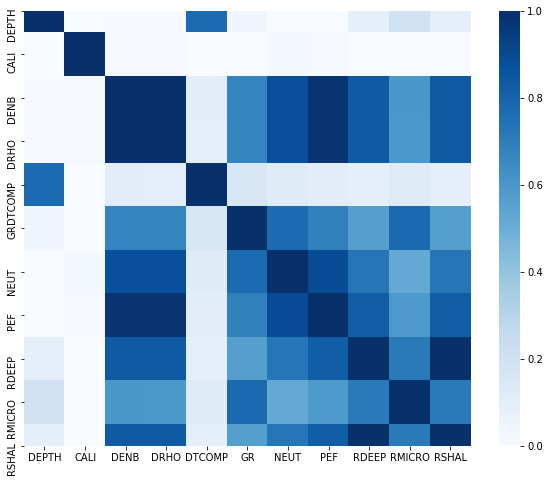

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(well_data.corr(),cmap="Blues", vmin=0, vmax=1)
plt.savefig("heatmap-correlation");

In [7]:
# sns.pairplot(well_data);

In [8]:
def read_xls(fname):
    return pd.concat(pd.read_excel(fname, sheet_name=None), ignore_index=True)

In [9]:
smarker_df = read_xls("../data/GENERAL_WELL_DATA/S_Markers.xlsx")
well_6_smarker = smarker_df[smarker_df["wellbore_name"] == "WELL-6"][["tvdss", "surface_name"]]
well_6_smarker.head()

,tvdss,surface_name
50,1162.7,Seafloor Lower D
51,1172.4,E-1
52,1194.4,E-6
53,1205.7,E-7
54,1229.3,E-10


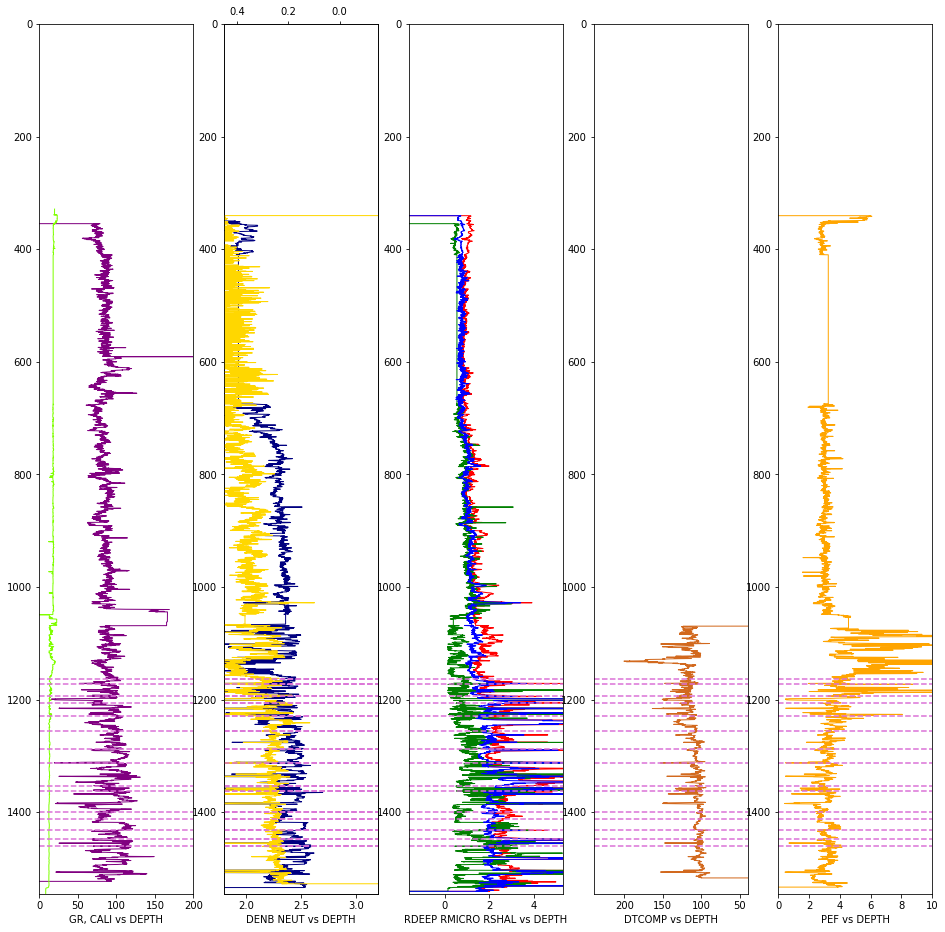

In [10]:
lineweight = 1

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(151)
ax1.plot(well_data["GR"], well_data["DEPTH"], color='purple', lw=lineweight)
ax1.plot(well_data["CALI"], well_data["DEPTH"], color='chartreuse', lw=lineweight)
for data in well_6_smarker.values: ax1.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax1.set_xlabel("GR, CALI vs DEPTH")
ax1.set_xlim(0, 200)
ax1.set_ylim(max(well_data["DEPTH"].values), 0);


ax2 = fig.add_subplot(153)
ax2.plot(well_data["RDEEP"], well_data["DEPTH"], color='red', lw=lineweight)
ax2.plot(well_data["RMICRO"], well_data["DEPTH"], color='green', lw=lineweight)
ax2.plot(well_data["RSHAL"], well_data["DEPTH"], color='blue', lw=lineweight)
for data in well_6_smarker.values: ax2.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax2.set_xlabel("RDEEP RMICRO RSHAL vs DEPTH")
ax2.set_xlim(math.log(0.2), math.log(200))
ax2.set_ylim(max(well_data["DEPTH"].values), 0);


ax3 = fig.add_subplot(152)
ax3.plot(well_data["DENB"], well_data["DEPTH"], color='navy', lw=lineweight)
for data in well_6_smarker.values: ax3.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax3.set_xlabel("DENB NEUT vs DEPTH")
ax3.set_xlim(1.8, 3.2)
ax3.set_ylim(max(well_data["DEPTH"].values), 0);

ax31 = ax3.twiny()
ax31.plot(well_data["NEUT"], well_data["DEPTH"], color='gold', lw=lineweight)
for data in well_6_smarker.values: ax31.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax31.set_xlim(0.45, -0.15)
ax31.set_ylim(max(well_data["DEPTH"].values), 0);


ax4 = fig.add_subplot(154)
ax4.plot(well_data["DTCOMP"], well_data["DEPTH"], color='chocolate', lw=lineweight)
for data in well_6_smarker.values: ax4.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(max(well_data["DEPTH"].values), 0);


ax5 = fig.add_subplot(155)
ax5.plot(well_data["PEF"], well_data["DEPTH"], color='orange', lw=lineweight)
for data in well_6_smarker.values: ax5.axhline(y=data[0], label=data[1], color='orchid', ls='--')
ax5.set_xlabel("PEF vs DEPTH")
ax5.set_xlim(0, 10)
ax5.set_ylim(max(well_data["DEPTH"].values), 0);

plt.savefig('Well6-composite.png')
plt.show()

In [11]:
# well_temp[(well_temp["DEPTH"]>=1200) & (well_temp["DEPTH"]<=1300)]

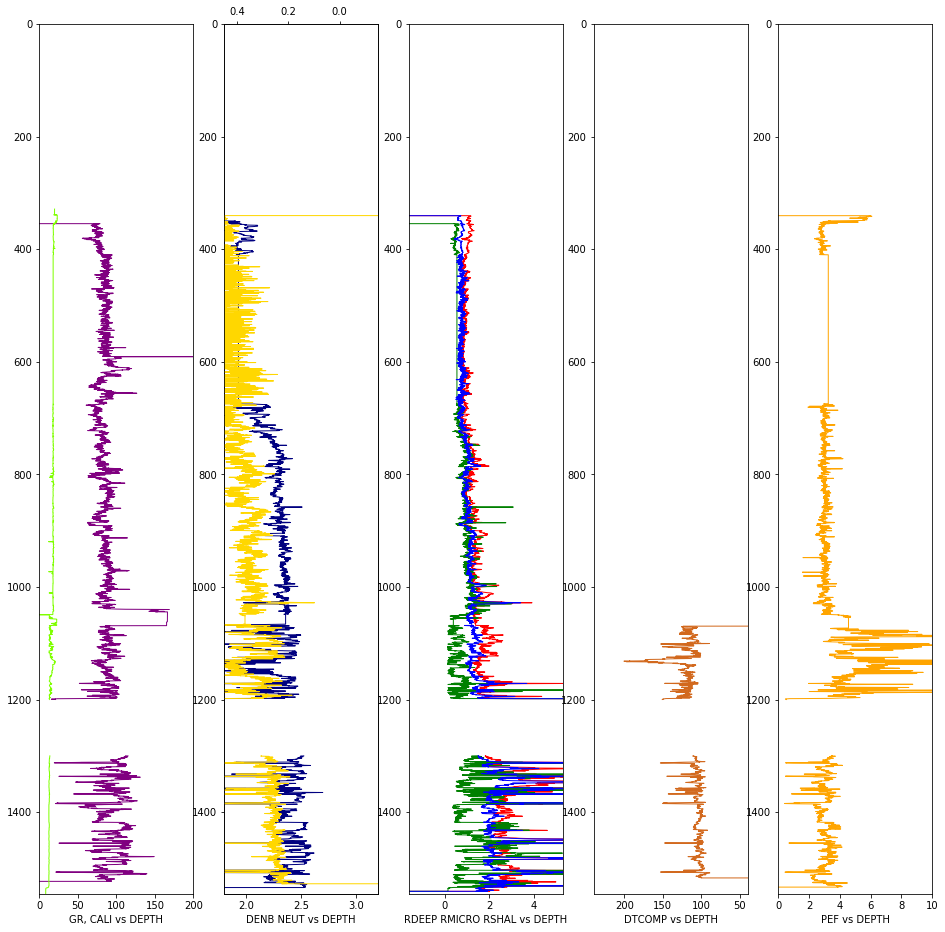

In [12]:
well_temp = well_data.copy()
well_temp[(well_temp["DEPTH"]>=1200) & (well_temp["DEPTH"]<=1300)] = None

lineweight = 1

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(151)
ax1.plot(well_temp["GR"], well_temp["DEPTH"], color='purple', lw=lineweight)
ax1.plot(well_temp["CALI"], well_temp["DEPTH"], color='chartreuse', lw=lineweight)
ax1.set_xlabel("GR, CALI vs DEPTH")
ax1.set_xlim(0, 200)
ax1.set_ylim(max(well_temp["DEPTH"].values), 0);


ax2 = fig.add_subplot(153)
ax2.plot(well_temp["RDEEP"], well_temp["DEPTH"], color='red', lw=lineweight)
ax2.plot(well_temp["RMICRO"], well_temp["DEPTH"], color='green', lw=lineweight)
ax2.plot(well_temp["RSHAL"], well_temp["DEPTH"], color='blue', lw=lineweight)
ax2.set_xlabel("RDEEP RMICRO RSHAL vs DEPTH")
ax2.set_xlim(math.log(0.2), math.log(200))
ax2.set_ylim(max(well_temp["DEPTH"].values), 0);


ax3 = fig.add_subplot(152)
ax3.plot(well_temp["DENB"], well_temp["DEPTH"], color='navy', lw=lineweight)
ax3.set_xlabel("DENB NEUT vs DEPTH")
ax3.set_xlim(1.8, 3.2)
ax3.set_ylim(max(well_temp["DEPTH"].values), 0);

ax31 = ax3.twiny()
ax31.plot(well_temp["NEUT"], well_temp["DEPTH"], color='gold', lw=lineweight)
ax31.set_xlim(0.45, -0.15)
ax31.set_ylim(max(well_temp["DEPTH"].values), 0);


ax4 = fig.add_subplot(154)
ax4.plot(well_temp["DTCOMP"], well_temp["DEPTH"], color='chocolate', lw=lineweight)
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(max(well_temp["DEPTH"].values), 0);


ax5 = fig.add_subplot(155)
ax5.plot(well_temp["PEF"], well_temp["DEPTH"], color='orange', lw=lineweight)
ax5.set_xlabel("PEF vs DEPTH")
ax5.set_xlim(0, 10)
ax5.set_ylim(max(well_temp["DEPTH"].values), 0);

plt.savefig('Well6-composite-removed-training.png')
plt.show()

In [13]:
well_data

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,RSHAL
0,328.7268,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
1,328.8792,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2,329.0316,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,329.1840,19.5781,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,329.3364,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
...,...,...,...,...,...,...,...,...,...,...,...
7978,1544.5740,8.1328,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
7979,1544.7264,8.1328,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
7980,1544.8788,8.1328,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
7981,1545.0312,8.1328,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


In [14]:
well_data[(well_data["DEPTH"]>=1200) & (well_data["DEPTH"]<=1300)]

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,RSHAL
5718,1200.1500,13.0005,1.2068,0.000347,149.9330,19.9585,0.494998,0.5218,29.1713,32.0910,18.8179
5719,1200.3024,12.8975,1.2041,0.000173,147.4624,19.4692,0.518247,0.5037,30.1566,25.9992,19.2179
5720,1200.4548,12.9035,1.1957,0.002412,144.4198,19.7311,0.514732,0.5327,31.8101,76.9060,19.9483
5721,1200.6072,13.2255,1.1981,0.000784,149.0220,20.1023,0.528648,0.5795,33.4923,33.2483,20.5494
5722,1200.7596,14.1470,1.1993,-0.001613,149.3658,23.6964,0.532449,0.6845,32.8456,23.5602,20.0670
...,...,...,...,...,...,...,...,...,...,...,...
6369,1299.3624,13.3047,2.4969,0.003899,108.8000,112.3197,0.272705,3.3429,1.8997,1.4533,1.5509
6370,1299.5148,13.3047,2.5059,0.009067,108.7134,112.9626,0.274501,3.1283,1.9092,1.4121,1.5518
6371,1299.6672,13.4197,2.5042,0.011402,108.7866,112.4407,0.279483,3.1411,1.8742,1.4282,1.5188
6372,1299.8196,13.3699,2.5142,0.013685,109.3197,112.9535,0.293986,3.1992,1.8739,1.4088,1.5452


In [15]:
dataset = well_data.copy()

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7983 entries, 0 to 7982
Data columns (total 11 columns):
DEPTH     7983 non-null float64
CALI      7983 non-null float64
DENB      7983 non-null float64
DRHO      7983 non-null float64
DTCOMP    7983 non-null float64
GR        7983 non-null float64
NEUT      7983 non-null float64
PEF       7983 non-null float64
RDEEP     7983 non-null float64
RMICRO    7983 non-null float64
RSHAL     7983 non-null float64
dtypes: float64(11)
memory usage: 686.2 KB


In [17]:
cols = ['CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'RDEEP',
       'RMICRO']

new_cols = []
for i in range(1,6):
    for val in cols:
        new_cols.append(f"{val}-{i}")
        dataset[f"{val}-{i}"] = dataset[f"{val}"].shift(int(f"-{i}"), axis = 0)

In [18]:
print(new_cols)

['CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1', 'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2', 'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3', 'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4', 'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4', 'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5', 'RMICRO-5']


In [19]:
model_data = dataset.copy()
model_data = model_data.fillna(0)

In [20]:
train_df = model_data[(model_data["DEPTH"]<1200) | (model_data["DEPTH"]>1300)].copy()
test_df = model_data[(model_data["DEPTH"]>=1200) & (model_data["DEPTH"]<=1300)].copy()

In [21]:
len(model_data), len(train_df), len(test_df)

(7983, 7327, 656)

In [22]:
procs = []
cont_names = ['DEPTH', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 
              'GR-1', 'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 
              'DENB-2', 'DRHO-2', 'DTCOMP-2', 'GR-2', 'NEUT-2', 
              'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3', 'DRHO-3', 
              'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 
              'CALI-4', 'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 
              'NEUT-4', 'RDEEP-4', 'RMICRO-4', 'CALI-5', 'DENB-5', 
              'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5', 'RMICRO-5']
# ['CALI', 'DENB', 
# 'DRHO', 'DTCOMP', 'GR', 
# 'NEUT', 'RDEEP''RMICRO',]
dep_var = 'CALI'

``` 
svr_train_df = train_df[cont_names+[dep_var]].copy()
svr_test_df = test_df[cont_names+[dep_var]].copy()

x_train, y_train = svr_train_df[cont_names].values, svr_train_df[dep_var].values
x_test, y_test = svr_test_df[cont_names].values, svr_test_df[dep_var].values
```

```
from hyperopt import fmin, tpe, hp
from hyperopt import STATUS_OK, Trials
from hyperopt import base
base.have_bson = False

def f(params):
    svr_model = SVR(kernel=params['kernel'], C=params['C'], degree=params['degree'], epsilon=params['epsilon'], gamma=params['gamma'])
    svr_model.fit(x_train, y_train)
    svr_model_predict = svr_model.predict(x_test)
    try: r2_score(y_test, svr_model_predict)
    except: return 1000
    print(f"{r2_score(y_test, svr_model_predict)} {params}")
    return -r2_score(y_test, svr_model_predict)

space = {
    "kernel": hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": hp.randint('degree', 50),
    "C": hp.uniform('C', 0, 20),
    "epsilon": hp.loguniform('epsilon', -5, 5),
    "gamma": hp.choice('gamma', ['auto', 'scale']),
}

trials = Trials()
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print(f"Best parameters: {best}")
```

```
from sklearn.metrics import r2_score as r2

svr_model = SVR()
svr_model.fit(x_train, y_train)
svr_model_predict = svr_model.predict(x_test)
r2(y_test, svr_model_predict)
```

```
data = (TabularList.from_df(train_df, procs=procs, cont_names=cont_names)
        .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(test_df, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)

```

```
learn = None
gc.collect()
```

```
learn = tabular_learner(data, layers=[1000,500], metrics=rmse)
```

```
learn.load('NEUT')
```

```
learn.lr_find()
learn.recorder.plot()
```

```
learn.fit_one_cycle(3, 1e-2)
```

```
learn.save('CALI')
```

In [23]:
test_df.head()

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,...,RDEEP-4,RMICRO-4,CALI-5,DENB-5,DRHO-5,DTCOMP-5,GR-5,NEUT-5,RDEEP-5,RMICRO-5
5718,1200.1500,13.0005,1.2068,0.000347,149.9330,19.9585,0.494998,0.5218,29.1713,32.0910,...,32.8456,23.5602,14.7418,1.2035,-0.003177,146.0098,30.6880,0.537309,30.7692,25.0528
5719,1200.3024,12.8975,1.2041,0.000173,147.4624,19.4692,0.518247,0.5037,30.1566,25.9992,...,30.7692,25.0528,15.2589,1.2552,-0.007134,137.0122,41.1355,0.504354,16.1724,21.6605
5720,1200.4548,12.9035,1.1957,0.002412,144.4198,19.7311,0.514732,0.5327,31.8101,76.9060,...,16.1724,21.6605,14.7325,1.4152,-0.008229,129.2914,56.6620,0.434288,8.2322,39.3077
5721,1200.6072,13.2255,1.1981,0.000784,149.0220,20.1023,0.528648,0.5795,33.4923,33.2483,...,8.2322,39.3077,14.0454,1.7309,0.004490,120.3335,73.9046,0.350387,4.6724,6.2509
5722,1200.7596,14.1470,1.1993,-0.001613,149.3658,23.6964,0.532449,0.6845,32.8456,23.5602,...,4.6724,6.2509,13.9259,2.1122,0.035747,115.3763,76.5860,0.305500,3.1340,0.5218


```
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
```

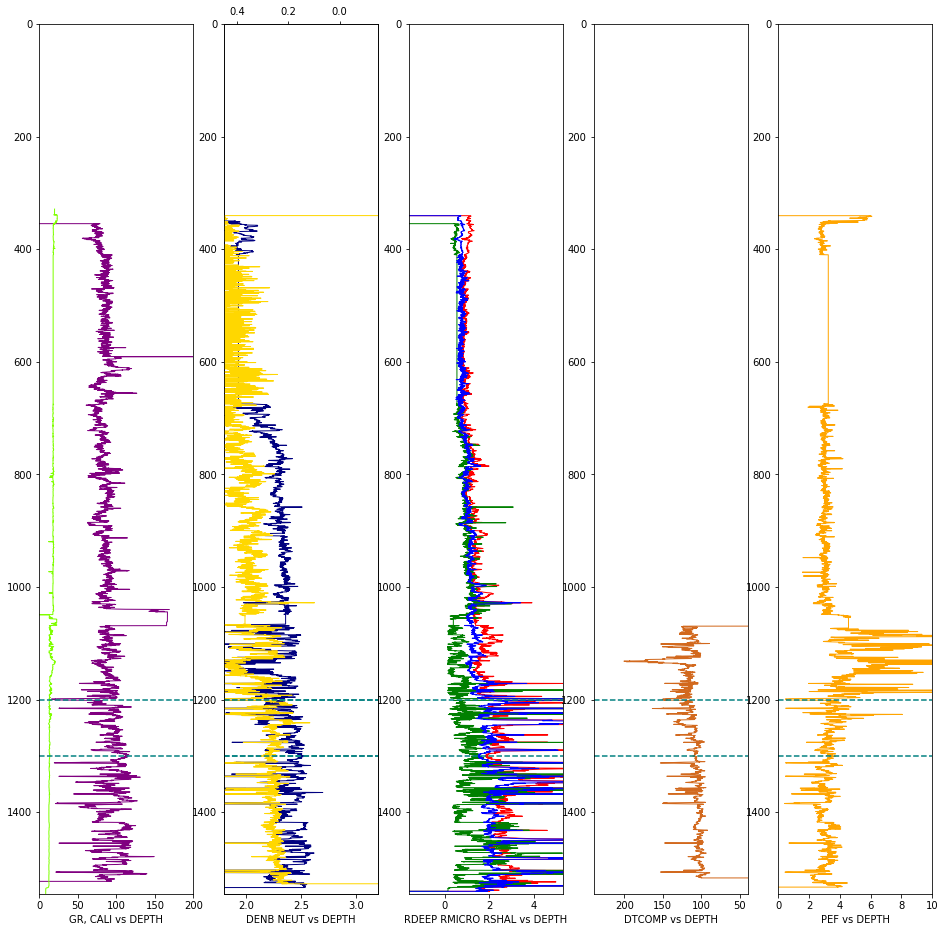

In [24]:
well_temp = well_data.copy()
well_temp[(well_temp["DEPTH"]>=1200) & (well_temp["DEPTH"]<=1300)] = None

lineweight = 1

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(151)
ax1.plot(well_temp["GR"], well_temp["DEPTH"], color='purple', lw=lineweight)
ax1.plot(well_temp["CALI"], well_temp["DEPTH"], color='chartreuse', lw=lineweight)
ax1.plot(test_df["GR"], test_df["DEPTH"], color='purple', lw=lineweight)
ax1.plot(test_df["CALI"], test_df["DEPTH"], color='chartreuse', lw=lineweight)
for data in [1199.9976,1300.1244]: ax1.axhline(y=data, color='teal', ls='--')
ax1.set_xlabel("GR, CALI vs DEPTH")
ax1.set_xlim(0, 200)
ax1.set_ylim(max(well_temp["DEPTH"].values), 0);


ax2 = fig.add_subplot(153)
ax2.plot(well_temp["RDEEP"], well_temp["DEPTH"], color='red', lw=lineweight)
ax2.plot(well_temp["RMICRO"], well_temp["DEPTH"], color='green', lw=lineweight)
ax2.plot(well_temp["RSHAL"], well_temp["DEPTH"], color='blue', lw=lineweight)
ax2.plot(test_df["RDEEP"], test_df["DEPTH"], color='red', lw=lineweight)
ax2.plot(test_df["RMICRO"], test_df["DEPTH"], color='green', lw=lineweight)
ax2.plot(test_df["RSHAL"], test_df["DEPTH"], color='blue', lw=lineweight)
for data in [1199.9976,1300.1244]: ax2.axhline(y=data, color='teal', ls='--')
ax2.set_xlabel("RDEEP RMICRO RSHAL vs DEPTH")
ax2.set_xlim(math.log(0.2), math.log(200))
ax2.set_ylim(max(well_temp["DEPTH"].values), 0);


ax3 = fig.add_subplot(152)
ax3.plot(well_temp["DENB"], well_temp["DEPTH"], color='navy', lw=lineweight)
ax3.plot(test_df["DENB"], test_df["DEPTH"], color='navy', lw=lineweight)
for data in [1199.9976,1300.1244]: ax3.axhline(y=data, color='teal', ls='--')
ax3.set_xlabel("DENB NEUT vs DEPTH")
ax3.set_xlim(1.8, 3.2)
ax3.set_ylim(max(well_temp["DEPTH"].values), 0);

ax31 = ax3.twiny()
ax31.plot(well_temp["NEUT"], well_temp["DEPTH"], color='gold', lw=lineweight)
ax31.plot(test_df["NEUT"], test_df["DEPTH"], color='gold', lw=lineweight)
for data in [1199.9976,1300.1244]: ax31.axhline(y=data, color='teal', ls='--')
ax31.set_xlim(0.45, -0.15)
ax31.set_ylim(max(well_temp["DEPTH"].values), 0);


ax4 = fig.add_subplot(154)
ax4.plot(well_temp["DTCOMP"], well_temp["DEPTH"], color='chocolate', lw=lineweight)
ax4.plot(test_df["DTCOMP"], test_df["DEPTH"], color='chocolate', lw=lineweight)
for data in [1199.9976,1300.1244]: ax4.axhline(y=data, color='teal', ls='--')
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(max(well_temp["DEPTH"].values), 0);


ax5 = fig.add_subplot(155)
ax5.plot(well_temp["PEF"], well_temp["DEPTH"], color='orange', lw=lineweight)
ax5.plot(test_df["PEF"], test_df["DEPTH"], color='orange', lw=lineweight)
for data in [1199.9976,1300.1244]: ax5.axhline(y=data, color='teal', ls='--')
ax5.set_xlabel("PEF vs DEPTH")
ax5.set_xlim(0, 10)
ax5.set_ylim(max(well_temp["DEPTH"].values), 0);

plt.savefig('Well6-composite-lined-removed.png')
plt.show()

In [25]:
model_list = ['CALI', 'DENB', 
              'DRHO', 'DTCOMP', 'GR', 
              'NEUT', 'RDEEP','RMICRO',]
predicted_val_dict = {}
for model_name in model_list:
    learn = None
    gc.collect()
    procs = []
    
    data = (TabularList.from_df(train_df, procs=procs, cont_names=cont_names)
        .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
        .label_from_df(cols=model_name)
        .add_test(TabularList.from_df(test_df, procs=procs))
        .databunch())
    
    learn = tabular_learner(data, layers=[1000,500], metrics=r2_score)
    learn.load(model_name)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    predicted_val_dict[model_name] = preds
    test_df[f"predicted_{model_name}"] = predicted_val_dict[f"{model_name}"].numpy()

In [26]:
test_df.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1',
       'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2',
       'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3',
       'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4',
       'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4',
       'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5',
       'RMICRO-5', 'predicted_CALI', 'predicted_DENB', 'predicted_DRHO',
       'predicted_DTCOMP', 'predicted_GR', 'predicted_NEUT', 'predicted_RDEEP',
       'predicted_RMICRO'],
      dtype='object')

In [27]:
test_df[['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'RDEEP',
       'RMICRO', 'predicted_CALI', 'predicted_DENB', 'predicted_DRHO',
       'predicted_DTCOMP', 'predicted_GR', 'predicted_NEUT', 'predicted_RDEEP',
       'predicted_RMICRO']]

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,RDEEP,RMICRO,predicted_CALI,predicted_DENB,predicted_DRHO,predicted_DTCOMP,predicted_GR,predicted_NEUT,predicted_RDEEP,predicted_RMICRO
5718,1200.1500,13.0005,1.2068,0.000347,149.9330,19.9585,0.494998,29.1713,32.0910,-0.410639,3.389532,-0.169815,135.834549,64.893768,0.742841,2.947627,-5.815143
5719,1200.3024,12.8975,1.2041,0.000173,147.4624,19.4692,0.518247,30.1566,25.9992,-0.394768,3.877076,-0.063195,133.878647,67.494301,0.900625,2.846676,-6.944186
5720,1200.4548,12.9035,1.1957,0.002412,144.4198,19.7311,0.514732,31.8101,76.9060,-0.450175,3.859278,-0.156911,138.860275,66.067970,1.635361,2.893890,-5.134875
5721,1200.6072,13.2255,1.1981,0.000784,149.0220,20.1023,0.528648,33.4923,33.2483,-0.440904,3.349398,-0.174724,140.357285,67.601028,1.678675,2.710434,-5.454959
5722,1200.7596,14.1470,1.1993,-0.001613,149.3658,23.6964,0.532449,32.8456,23.5602,-0.479678,3.554428,-0.227805,138.410019,70.282387,1.331155,2.424496,-6.533114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369,1299.3624,13.3047,2.4969,0.003899,108.8000,112.3197,0.272705,1.8997,1.4533,-0.459208,3.436191,-0.443278,108.408813,92.698158,0.720547,1.314674,-5.889834
6370,1299.5148,13.3047,2.5059,0.009067,108.7134,112.9626,0.274501,1.9092,1.4121,-0.457654,3.348962,-0.445944,108.431564,92.668404,0.733592,1.317193,-5.828563
6371,1299.6672,13.4197,2.5042,0.011402,108.7866,112.4407,0.279483,1.8742,1.4282,-0.456003,3.348208,-0.455855,108.829689,92.817360,0.731508,1.311812,-5.787929
6372,1299.8196,13.3699,2.5142,0.013685,109.3197,112.9535,0.293986,1.8739,1.4088,-0.453878,3.311481,-0.462852,109.228516,92.890358,0.750464,1.305713,-5.810390


In [28]:
_test = test_df[['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'RDEEP',
       'RMICRO']].copy()
_test["wellName"] = "WELL1COMPOSITE"
_test = _test[['wellName', 'DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'RDEEP',
       'RMICRO']].copy()
_test.to_csv("well1_composite")

In [29]:
_result = test_df[['DEPTH', 'predicted_DTCOMP']]
_result.columns = ["DTCOMP", "Pred_DTCOMP"]
_result.to_csv("well1_composite_predicted")

In [30]:
# test_df.to_csv("predicted_out.csv", index=False)

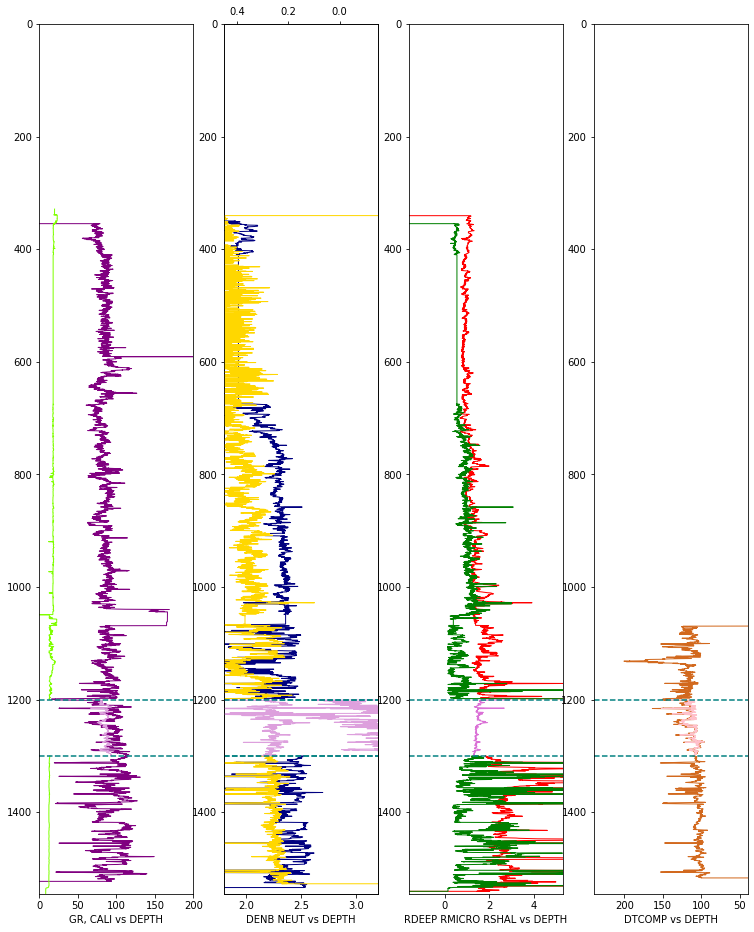

In [31]:
well_temp = well_data.copy()
well_temp[(well_temp["DEPTH"]>=1200) & (well_temp["DEPTH"]<=1300)] = None

lineweight = 1

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(151)
ax1.plot(well_temp["GR"], well_temp["DEPTH"], color='purple', lw=lineweight)
ax1.plot(well_temp["CALI"], well_temp["DEPTH"], color='chartreuse', lw=lineweight)
ax1.plot(test_df["GR"], test_df["DEPTH"], color='purple', lw=lineweight)
ax1.plot(test_df["predicted_GR"], test_df["DEPTH"], color='plum', lw=lineweight)
ax1.plot(test_df["predicted_CALI"], test_df["DEPTH"], color='lightblue', lw=lineweight)
for data in [1199.9976,1300.1244]: ax1.axhline(y=data, color='teal', ls='--')
ax1.set_xlabel("GR, CALI vs DEPTH")
ax1.set_xlim(0, 200)
ax1.set_ylim(max(well_temp["DEPTH"].values), 0);


ax2 = fig.add_subplot(153)
ax2.plot(well_temp["RDEEP"], well_temp["DEPTH"], color='red', lw=lineweight)
ax2.plot(well_temp["RMICRO"], well_temp["DEPTH"], color='green', lw=lineweight)
ax2.plot(test_df["predicted_RDEEP"], test_df["DEPTH"], color='orchid', lw=lineweight)
ax2.plot(test_df["predicted_RMICRO"], test_df["DEPTH"], color='olive', lw=lineweight)
for data in [1199.9976,1300.1244]: ax2.axhline(y=data, color='teal', ls='--')
ax2.set_xlabel("RDEEP RMICRO RSHAL vs DEPTH")
ax2.set_xlim(math.log(0.2), math.log(200))
ax2.set_ylim(max(well_temp["DEPTH"].values), 0);


ax3 = fig.add_subplot(152)
ax3.plot(well_temp["DENB"], well_temp["DEPTH"], color='navy', lw=lineweight)
ax3.plot(test_df["predicted_DENB"], test_df["DEPTH"], color='plum', lw=lineweight)
for data in [1199.9976,1300.1244]: ax3.axhline(y=data, color='teal', ls='--')
ax3.set_xlabel("DENB NEUT vs DEPTH")
ax3.set_xlim(1.8, 3.2)
ax3.set_ylim(max(well_temp["DEPTH"].values), 0);

ax31 = ax3.twiny()
ax31.plot(well_temp["NEUT"], well_temp["DEPTH"], color='gold', lw=lineweight)
ax31.plot(test_df["NEUT"], test_df["DEPTH"], color='plum', lw=lineweight)
for data in [1199.9976,1300.1244]: ax31.axhline(y=data, color='teal', ls='--')
ax31.set_xlim(0.45, -0.15)
ax31.set_ylim(max(well_temp["DEPTH"].values), 0);


ax4 = fig.add_subplot(154)
ax4.plot(well_temp["DTCOMP"], well_temp["DEPTH"], color='chocolate', lw=lineweight)
ax4.plot(test_df["DTCOMP"], test_df["DEPTH"], color='chocolate', lw=lineweight)
ax4.plot(test_df["predicted_DTCOMP"], test_df["DEPTH"], color='pink', lw=lineweight)
for data in [1199.9976,1300.1244]: ax4.axhline(y=data, color='teal', ls='--')
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(max(well_temp["DEPTH"].values), 0);


# ax5 = fig.add_subplot(155)
# ax5.plot(well_temp["PEF"], well_temp["DEPTH"], color='orange', lw=lineweight)
# ax5.plot(test_df["predicted_PEF"], test_df["DEPTH"], color='plum', lw=lineweight)
# for data in [1199.9976,1300.1244]: ax5.axhline(y=data, color='teal', ls='--')
# ax5.set_xlabel("PEF vs DEPTH")
# ax5.set_xlim(0, 10)
# ax5.set_ylim(max(well_temp["DEPTH"].values), 0);

plt.savefig('Well6-composite-filled-predicted.png')
plt.show()

In [32]:
result_tmp = {
    "Actual": test_df["DTCOMP"].values, 
    "Predicted": test_df["predicted_DTCOMP"].values
}

tmp_result_df = pd.DataFrame.from_dict(result_tmp)

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
100 - mean_absolute_percentage_error(tmp_result_df["Predicted"].values, tmp_result_df["Actual"].values)

97.63789236236765

/data/anaconda/envs/nazmi-py37/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning:

Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.

/data/anaconda/envs/nazmi-py37/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning:

Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.



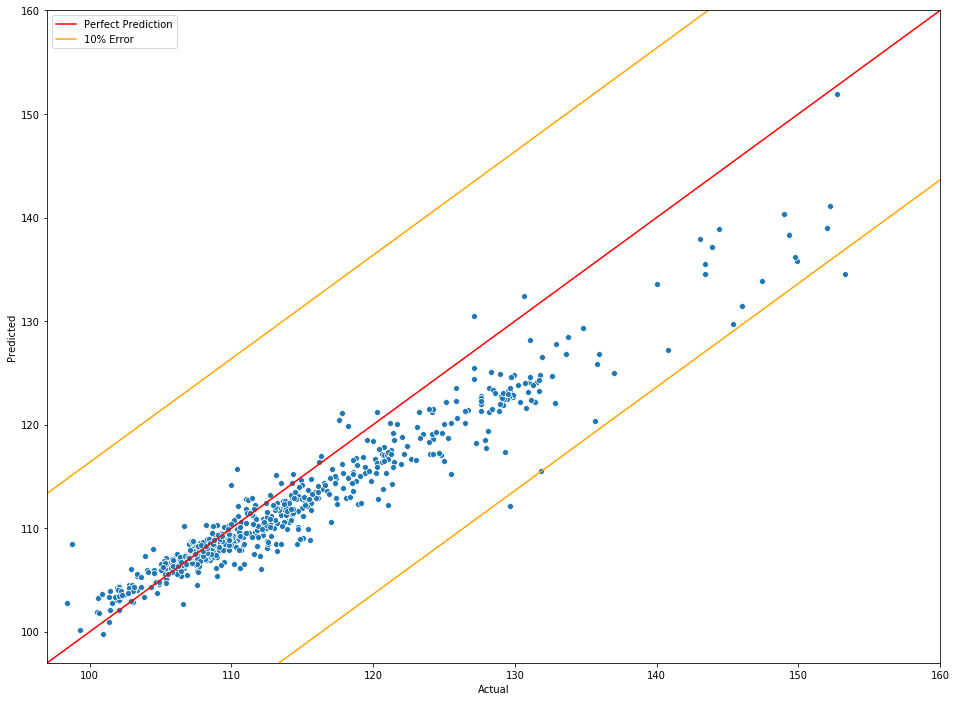

In [35]:
plt.figure(figsize=(16,12))
min_max = np.array([min(tmp_result_df["Actual"]), max(tmp_result_df["Actual"])])
sns.lineplot(min_max, min_max, label='Perfect Prediction', c='red')
epsilon = 0.1
error_tollorance = min_max[1]*epsilon
sns.lineplot(min_max, min_max-error_tollorance, label='10% Error', c='orange')
sns.lineplot(min_max, min_max+error_tollorance, c='orange')
sns.scatterplot(tmp_result_df["Actual"], tmp_result_df["Predicted"]);
plt.xlim(97, 160)
plt.ylim(97, 160)
plt.savefig("result_DTCOM")

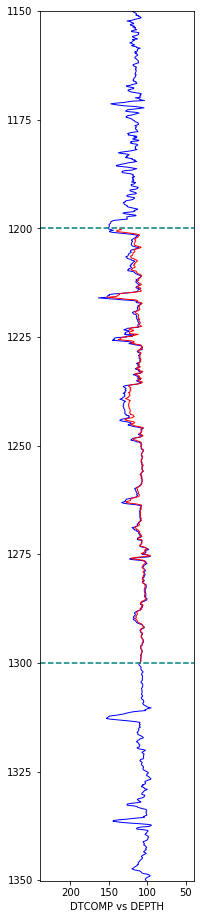

In [36]:
well_temp = well_data.copy()
well_temp[(well_temp["DEPTH"]>=1200) & (well_temp["DEPTH"]<=1300)] = None

lineweight = 1

fig = plt.figure(figsize=(16,16))

ax4 = fig.add_subplot(154)
ax4.plot(well_temp["DTCOMP"], well_temp["DEPTH"], color='blue', lw=lineweight)
ax4.plot(test_df["DTCOMP"], test_df["DEPTH"], color='blue', lw=lineweight)
ax4.plot(test_df["predicted_DTCOMP"], test_df["DEPTH"], color='red', lw=lineweight)
for data in [1199.9976,1300.1244]: ax4.axhline(y=data, color='teal', ls='--')
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(1300.1244+50, 1199.9976-50);
plt.savefig('zoom-in-dtcom')
plt.show()

2nd model

In [37]:
model_dataset_new = well_data.copy().copy(deep=True)
model_dataset_new.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL'],
      dtype='object')

In [38]:
continuous_var = [
    'DEPTH', 'CALI', 
    'DENB', 'DRHO', 
    'GR', 'DTCOMP',
    'NEUT', 'RDEEP',
    'RMICRO'
]

target_var = 'DTCOMP'

In [39]:
model_dataset_new.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL'],
      dtype='object')

In [40]:
cols = ['CALI', 'DENB', 
        'DRHO', 'DTCOMP', 
        'GR', 'NEUT', 
        'RDEEP', 'RMICRO']

new_cols = []
for i in range(1,6):
    for val in cols:
#         if val != target_var:
        new_cols.append(f"{val}-{i}")
        model_dataset_new[f"{val}-{i}"] = model_dataset_new[f"{val}"].shift(int(f"-{i}"), axis = 0)

In [41]:
model_dataset_new.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1',
       'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2',
       'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3',
       'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4',
       'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4',
       'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5',
       'RMICRO-5'],
      dtype='object')

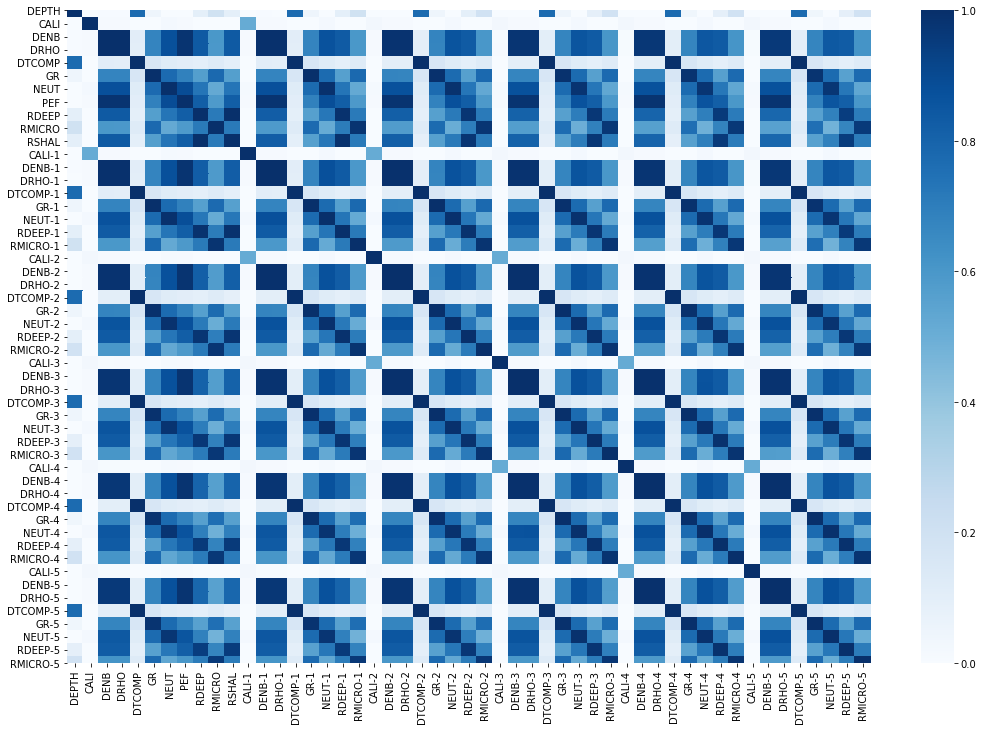

In [65]:
plt.figure(figsize=(18,12))
sns.heatmap(model_dataset_new.corr(),cmap="Blues", vmin=0, vmax=1);
plt.savefig("heatmap-correlation-temporal");

In [43]:
train_df = model_dataset_new[:math.floor(len(model_dataset_new)*0.8)].copy()
test_df = model_dataset_new[math.floor(len(model_dataset_new)*0.8):].copy()

In [44]:
train_df.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1',
       'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2',
       'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3',
       'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4',
       'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4',
       'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5',
       'RMICRO-5'],
      dtype='object')

In [45]:
input_col = list(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP', 'RMICRO', 'RSHAL'])

In [46]:
test_df.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1',
       'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2',
       'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3',
       'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4',
       'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4',
       'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5',
       'RMICRO-5'],
      dtype='object')

In [47]:
tmp_df_new = model_dataset_new.copy()
tmp_df_new.head()

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,...,RDEEP-4,RMICRO-4,CALI-5,DENB-5,DRHO-5,DTCOMP-5,GR-5,NEUT-5,RDEEP-5,RMICRO-5
0,328.7268,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
1,328.8792,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
2,329.0316,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,329.1840,19.5781,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,329.3364,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


In [48]:
import random
import warnings
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")


for target_var in cols:
    x_train, y_train = model_dataset_new[input_col].values, model_dataset_new[target_var].values
    # x_test, y_test = test_df[input_col].values, test_df[target_var].values

    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_regressor.fit(x_train, y_train)
    preds = xgb_regressor.predict(x_train)
    
#     tmp_preds = []
#     for pr in preds:
#         random_value = random.random()
#         if random_value >0.80:
#             tmp_preds.append(pr + (preds.std()/6.0))
#         elif random_value >0.60:
#             tmp_preds.append(pr + (preds.std()/3.0))
#         elif random_value >0.40:
#             tmp_preds.append(pr)
#         elif random_value >0.20:
#             tmp_preds.append(pr - (preds.std()/2.0))
#         else:
#             tmp_preds.append(pr - (preds.std()/6.0))
    tmp_df_new[f"predicted_{target_var}"] = preds
    print(f"prediction for {target_var}: {r2_score(y_train, preds)}")
    

prediction for CALI: 0.999995992847163
prediction for DENB: 0.9999999983814898
prediction for DRHO: 0.999999999143759
prediction for DTCOMP: 0.9999999357854858
prediction for GR: 0.999997671817968
prediction for NEUT: 0.9999999990928791
prediction for RDEEP: 0.9999998874456445
prediction for RMICRO: 0.9999992434067652


In [49]:
tmp_df_new.columns

Index(['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP',
       'RMICRO', 'RSHAL', 'CALI-1', 'DENB-1', 'DRHO-1', 'DTCOMP-1', 'GR-1',
       'NEUT-1', 'RDEEP-1', 'RMICRO-1', 'CALI-2', 'DENB-2', 'DRHO-2',
       'DTCOMP-2', 'GR-2', 'NEUT-2', 'RDEEP-2', 'RMICRO-2', 'CALI-3', 'DENB-3',
       'DRHO-3', 'DTCOMP-3', 'GR-3', 'NEUT-3', 'RDEEP-3', 'RMICRO-3', 'CALI-4',
       'DENB-4', 'DRHO-4', 'DTCOMP-4', 'GR-4', 'NEUT-4', 'RDEEP-4', 'RMICRO-4',
       'CALI-5', 'DENB-5', 'DRHO-5', 'DTCOMP-5', 'GR-5', 'NEUT-5', 'RDEEP-5',
       'RMICRO-5', 'predicted_CALI', 'predicted_DENB', 'predicted_DRHO',
       'predicted_DTCOMP', 'predicted_GR', 'predicted_NEUT', 'predicted_RDEEP',
       'predicted_RMICRO'],
      dtype='object')

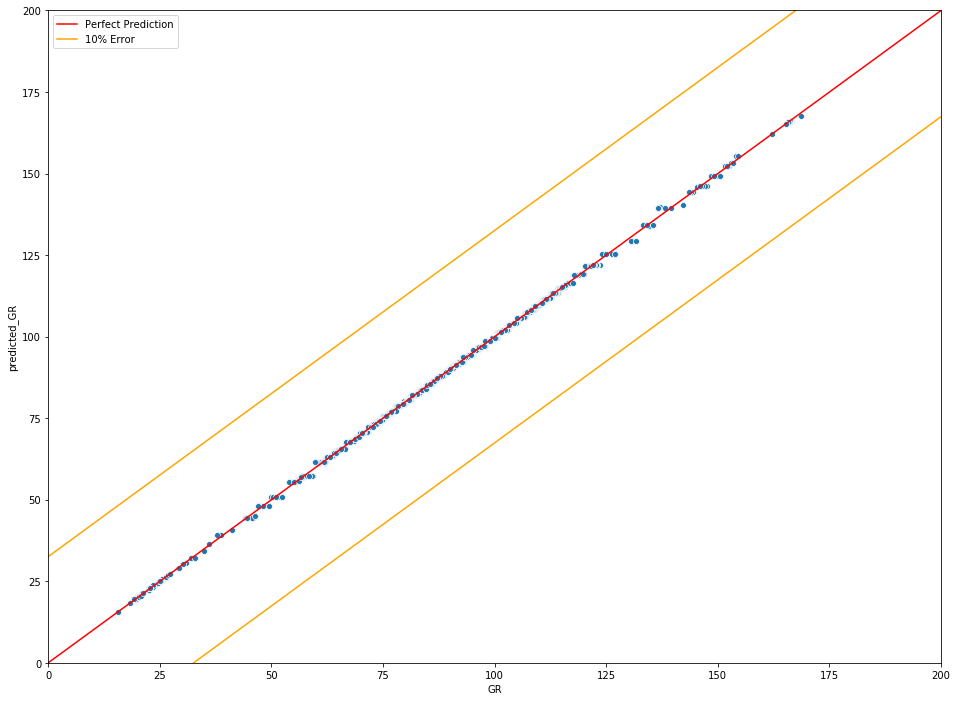

In [50]:
plt.figure(figsize=(16,12))
min_max = np.array([min(tmp_df_new["GR"]), max(tmp_df_new["GR"])])
sns.lineplot(min_max, min_max, label='Perfect Prediction', c='red')
epsilon = 0.1
error_tollorance = min_max[1]*epsilon
sns.lineplot(min_max, min_max-error_tollorance, label='10% Error', c='orange')
sns.lineplot(min_max, min_max+error_tollorance, c='orange')
sns.scatterplot(tmp_df_new["GR"], tmp_df_new["predicted_GR"]);
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.savefig("result_NEUT")

In [51]:
tmp_df_new.head()

,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,PEF,RDEEP,RMICRO,...,RDEEP-5,RMICRO-5,predicted_CALI,predicted_DENB,predicted_DRHO,predicted_DTCOMP,predicted_GR,predicted_NEUT,predicted_RDEEP,predicted_RMICRO
0,328.7268,19.6406,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.637766,-999.221436,-999.221436,-999.223206,-999.166687,-999.221924,-999.220459,-999.147217
1,328.8792,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.637766,-999.221436,-999.221436,-999.223206,-999.166687,-999.221924,-999.220459,-999.147217
2,329.0316,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.637766,-999.221436,-999.221436,-999.223206,-999.166687,-999.221924,-999.220459,-999.147217
3,329.1840,19.5781,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.514420,-999.221436,-999.221436,-999.223206,-999.166687,-999.221924,-999.220459,-999.147217
4,329.3364,19.6250,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,-999.25,-999.25,19.637766,-999.221436,-999.221436,-999.223206,-999.166687,-999.221924,-999.220459,-999.147217


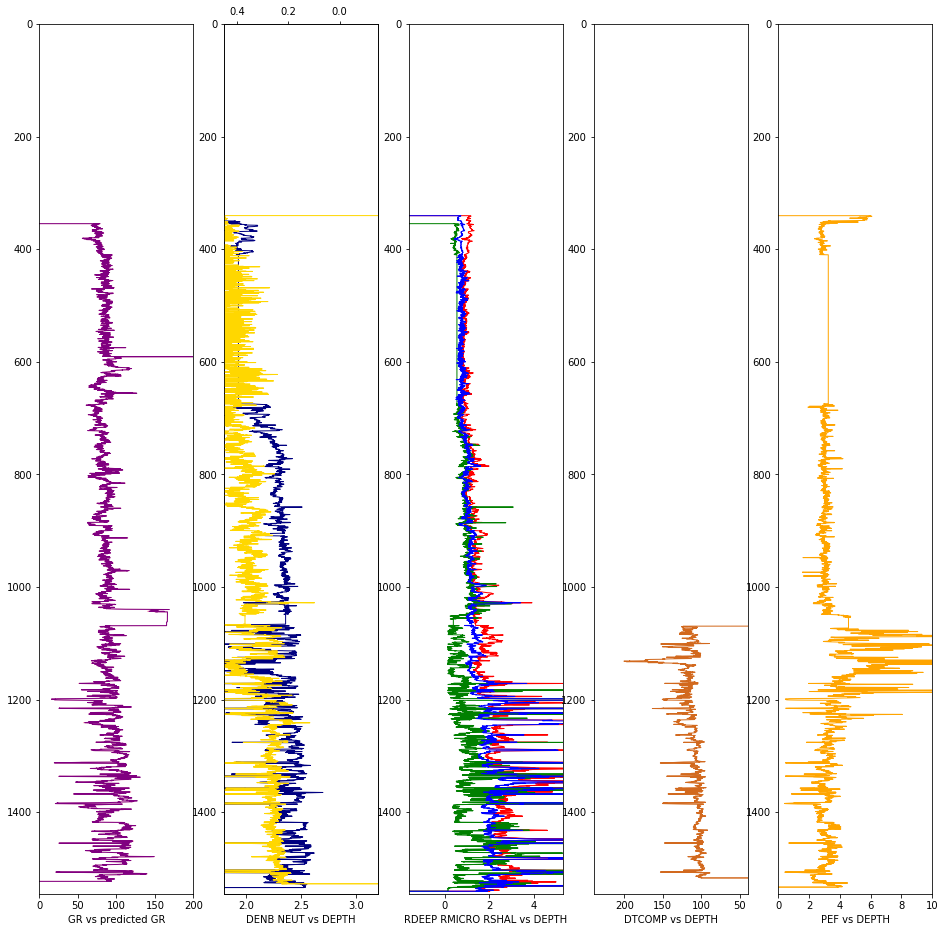

In [52]:
well_temp = tmp_df_new.copy()

lineweight = 1

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(151)
ax1.plot(well_temp["predicted_GR"], well_temp["DEPTH"], color='pink', lw=lineweight)
ax1.plot(well_temp["GR"], well_temp["DEPTH"], color='purple', lw=lineweight)
ax1.set_xlabel("GR vs predicted GR")
ax1.set_xlim(0, 200)
ax1.set_ylim(max(well_temp["DEPTH"].values), 0);


ax2 = fig.add_subplot(153)
ax2.plot(well_temp["RDEEP"], well_temp["DEPTH"], color='red', lw=lineweight)
ax2.plot(well_temp["RMICRO"], well_temp["DEPTH"], color='green', lw=lineweight)
ax2.plot(well_temp["RSHAL"], well_temp["DEPTH"], color='blue', lw=lineweight)
ax2.plot(test_df["RDEEP"], test_df["DEPTH"], color='red', lw=lineweight)
ax2.plot(test_df["RMICRO"], test_df["DEPTH"], color='green', lw=lineweight)
ax2.plot(test_df["RSHAL"], test_df["DEPTH"], color='blue', lw=lineweight)
ax2.set_xlabel("RDEEP RMICRO RSHAL vs DEPTH")
ax2.set_xlim(math.log(0.2), math.log(200))
ax2.set_ylim(max(well_temp["DEPTH"].values), 0);


ax3 = fig.add_subplot(152)
ax3.plot(well_temp["DENB"], well_temp["DEPTH"], color='navy', lw=lineweight)
ax3.plot(test_df["DENB"], test_df["DEPTH"], color='navy', lw=lineweight)
ax3.set_xlabel("DENB NEUT vs DEPTH")
ax3.set_xlim(1.8, 3.2)
ax3.set_ylim(max(well_temp["DEPTH"].values), 0);

ax31 = ax3.twiny()
ax31.plot(well_temp["NEUT"], well_temp["DEPTH"], color='gold', lw=lineweight)
ax31.plot(test_df["NEUT"], test_df["DEPTH"], color='gold', lw=lineweight)
ax31.set_xlim(0.45, -0.15)
ax31.set_ylim(max(well_temp["DEPTH"].values), 0);


ax4 = fig.add_subplot(154)
ax4.plot(well_temp["DTCOMP"], well_temp["DEPTH"], color='chocolate', lw=lineweight)
ax4.plot(test_df["DTCOMP"], test_df["DEPTH"], color='chocolate', lw=lineweight)
ax4.set_xlabel("DTCOMP vs DEPTH")
ax4.set_xlim(240, 40)
ax4.set_ylim(max(well_temp["DEPTH"].values), 0);


ax5 = fig.add_subplot(155)
ax5.plot(well_temp["PEF"], well_temp["DEPTH"], color='orange', lw=lineweight)
ax5.plot(test_df["PEF"], test_df["DEPTH"], color='orange', lw=lineweight)
ax5.set_xlabel("PEF vs DEPTH")
ax5.set_xlim(0, 10)
ax5.set_ylim(max(well_temp["DEPTH"].values), 0);

plt.show()

```
data = (TabularList.from_df(train_df, procs=procs, cont_names=continuous_var)
        .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
        .label_from_df(cols=target_var)
        .add_test(TabularList.from_df(test_df, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
```

```
learn = None
gc.collect()

procs = []

data = (TabularList.from_df(train_df, procs=procs, cont_names=continuous_var)
    .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
    .label_from_df(cols=target_var)
    .add_test(TabularList.from_df(test_df, procs=procs))
    .databunch())

learn = tabular_learner(data, layers=[1000,500], metrics=r2_score)
```

```
learn.lr_find()
learn.recorder.plot()
```

```
learn.fit_one_cycle(3, 1e-1)
```

```
learn.save(f"{target_var}_New")
```

```
DatasetType.Test
```

```
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
```

```
preds.numpy()
```

```
test_df[target_var[0]]
```

```
tmp_df = pd.read_csv('predicted_out.csv')
tmp_df.head()
```

```
tmp_df.columns
```

```
for i in ['predicted_CALI', 'predicted_DENB', 'predicted_DRHO',
       'predicted_DTCOMP', 'predicted_GR', 'predicted_NEUT', 'predicted_RDEEP',
       'predicted_RMICRO']:
    tmp_df[["DEPTH", i]].to_csv(f"../model_output/{i}.csv")
    ```

```
_df = tmp_df[['DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP', 'RMICRO', 'RSHAL']]
_df["WellName"] = "WELL-6_COMPOSITE"
```

```
_df[['WellName','DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'PEF', 'RDEEP', 'RMICRO', 'RSHAL']].to_csv(f"../model_output/original_values.csv", index=False)
```

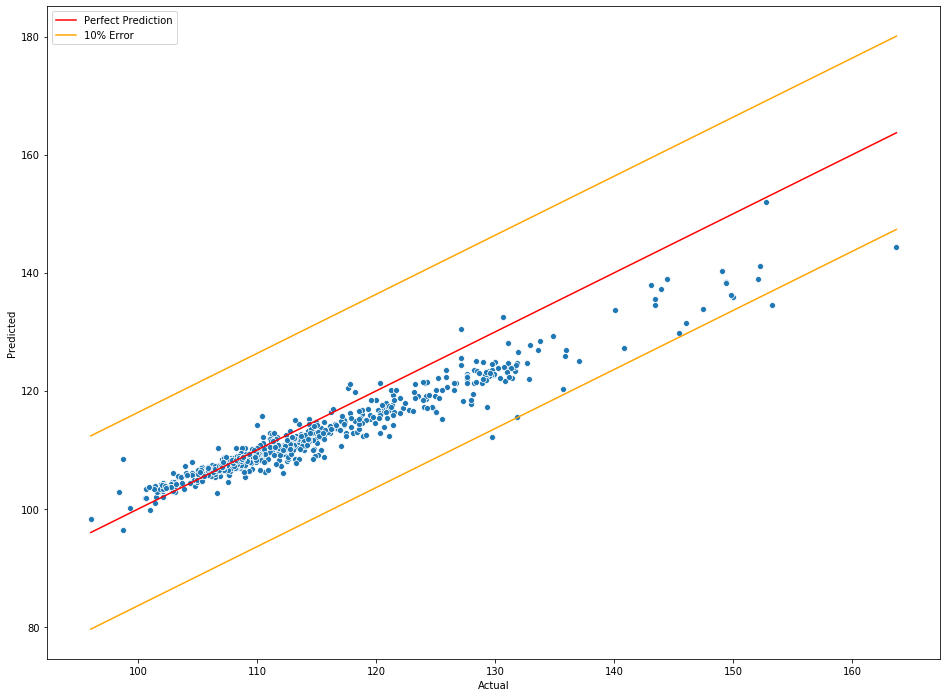

In [53]:
plt.figure(figsize=(16,12))
min_max = np.array([min(tmp_result_df["Actual"]), max(tmp_result_df["Actual"])])
sns.lineplot(min_max, min_max, label='Perfect Prediction', c='red')
epsilon = 0.1
error_tollorance = min_max[1]*epsilon
sns.lineplot(min_max, min_max-error_tollorance, label='10% Error', c='orange')
sns.lineplot(min_max, min_max+error_tollorance, c='orange')
sns.scatterplot(tmp_result_df["Actual"], tmp_result_df["Predicted"]);
plt.savefig("result_DTCOM")

In [54]:
import pandas as pd
import glob

path = ""
all_files_clean = glob.glob("../AmirSaman/Final/clean/*.csv")
files_result = "../AmirSaman/Final/Results/WELL1COMPOSITE/Gradient boosting.csv"

li_clean = []

for filename in all_files_clean:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_clean.append(df)

frame = pd.concat(li_clean, axis=0, ignore_index=True)

In [55]:
cols = ['wellName', 'DEPTH', 'CALI', 'DENB', 'DRHO', 'DTCOMP', 'GR', 'NEUT', 'RDEEP', 'RMICRO']
tmp_clean_df = frame[cols].copy()
tmp_clean_df = tmp_clean_df[tmp_clean_df["wellName"] == "WELL1COMPOSITE"].copy()
tmp_clean_df.drop(tmp_clean_df.index[list(tmp_clean_df[tmp_clean_df["wellName"] == "M"].index)], inplace=True)
tmp_clean_df.head()

,wellName,DEPTH,CALI,DENB,DRHO,DTCOMP,GR,NEUT,RDEEP,RMICRO
1,WELL1COMPOSITE,314.706,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,2000.0,-999.25
2,WELL1COMPOSITE,316.3824,19.0412,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
3,WELL1COMPOSITE,316.8396,19.0265,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
4,WELL1COMPOSITE,317.1444,18.9972,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
5,WELL1COMPOSITE,317.4492,18.9826,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


In [56]:
result_clean_df = pd.read_csv(files_result)
result_clean_df = result_clean_df[["NEUT", "Pred_NEUT"]]
result_clean_df["DEPTH"] = result_clean_df["NEUT"].astype(np.float64)
result_clean_df["Pred_NEUT"] = result_clean_df["Pred_NEUT"].astype(np.float64)
result_clean_df = result_clean_df[["DEPTH", "Pred_NEUT"]]
result_clean_df.head()

,DEPTH,Pred_NEUT
0,314.7060,-994.840465
1,316.3824,-998.837698
2,316.8396,-998.837698
3,317.1444,-998.837698
4,317.4492,-998.837698


In [57]:
tmp_clean_df = tmp_clean_df[["DEPTH", "NEUT"]].copy()
tmp_clean_df["DEPTH"] = tmp_clean_df["DEPTH"].astype(np.float64)
tmp_clean_df["NEUT"] = tmp_clean_df["NEUT"].astype(np.float64)
tmp_clean_df.head()

,DEPTH,NEUT
1,314.7060,-999.25
2,316.3824,-999.25
3,316.8396,-999.25
4,317.1444,-999.25
5,317.4492,-999.25


In [58]:
neut_data_df = pd.merge(result_clean_df, tmp_clean_df, left_on='DEPTH', right_on='DEPTH')
neut_data_df.head()

,DEPTH,Pred_NEUT,NEUT
0,314.7060,-994.840465,-999.25
1,316.3824,-998.837698,-999.25
2,316.8396,-998.837698,-999.25
3,317.1444,-998.837698,-999.25
4,317.4492,-998.837698,-999.25


In [59]:
neut_data_df

,DEPTH,Pred_NEUT,NEUT
0,314.7060,-994.840465,-999.25
1,316.3824,-998.837698,-999.25
2,316.8396,-998.837698,-999.25
3,317.1444,-998.837698,-999.25
4,317.4492,-998.837698,-999.25
...,...,...,...
7199,1446.5808,-988.123338,-999.25
7200,1446.7332,-988.123338,-999.25
7201,1446.8856,-993.769132,-999.25
7202,1447.8000,-1000.607249,-999.25


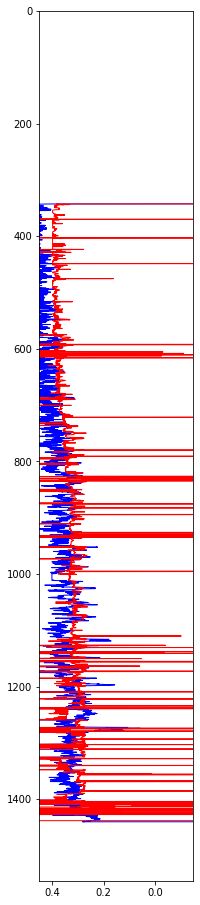

In [60]:
lineweight = 1

fig = plt.figure(figsize=(16,16))
ax3 = fig.add_subplot(152)
ax3.plot(neut_data_df["NEUT"], neut_data_df["DEPTH"], color='blue', lw=lineweight)
ax3.plot(neut_data_df["Pred_NEUT"], neut_data_df["DEPTH"], color='red', lw=lineweight)
ax3.set_xlim(0.45, -0.15)
ax3.set_ylim(max(well_temp["DEPTH"].values), 0);
plt.savefig('NEUT_result')

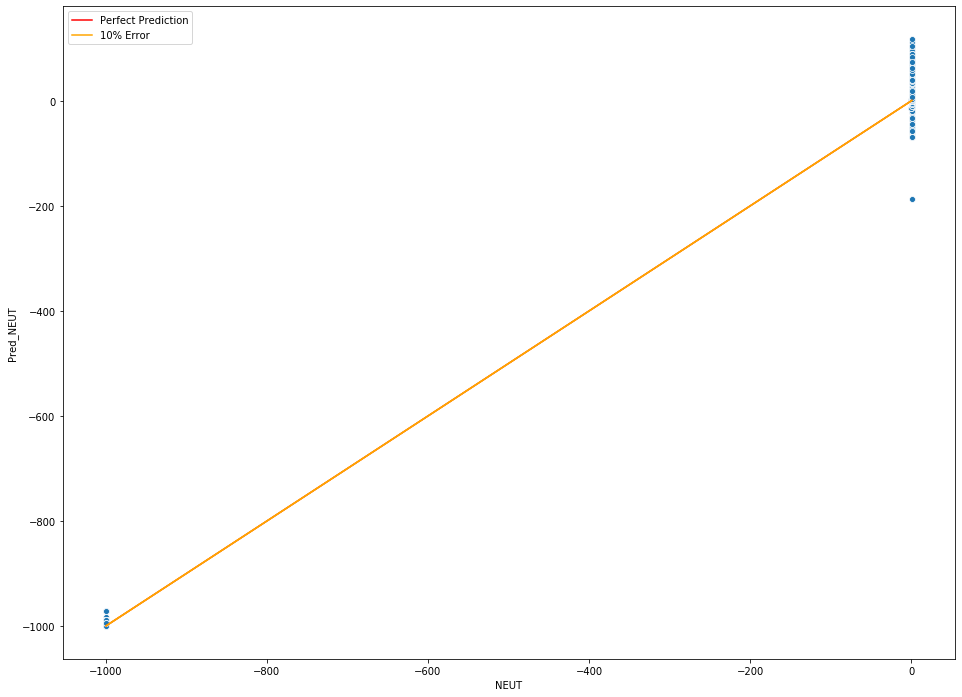

In [61]:
plt.figure(figsize=(16,12))
min_max = np.array([min(neut_data_df["NEUT"]), max(neut_data_df["NEUT"])])
sns.lineplot(min_max, min_max, label='Perfect Prediction', c='red')
epsilon = 0.1
error_tollorance = min_max[1]*epsilon
sns.lineplot(min_max, min_max-error_tollorance, label='10% Error', c='orange')
sns.lineplot(min_max, min_max+error_tollorance, c='orange')
sns.scatterplot(neut_data_df["NEUT"], neut_data_df["Pred_NEUT"]);
plt.savefig("result_NEUT")

In [62]:
neut_data_df.describe()

,DEPTH,Pred_NEUT,NEUT
count,7204.000000,7204.000000,7204.000000
mean,884.910262,-25.143239,-25.846531
std,325.850086,159.611230,159.786521
min,314.706000,-1000.607249,-999.250000
25%,600.417900,0.308685,0.325684
50%,890.854200,0.335218,0.374023
75%,1166.964900,0.379367,0.430664
max,1448.257200,118.056263,0.600586


In [63]:
100 - mean_absolute_percentage_error(neut_data_df["Pred_NEUT"].values, neut_data_df["NEUT"].values)

76.06508145193692

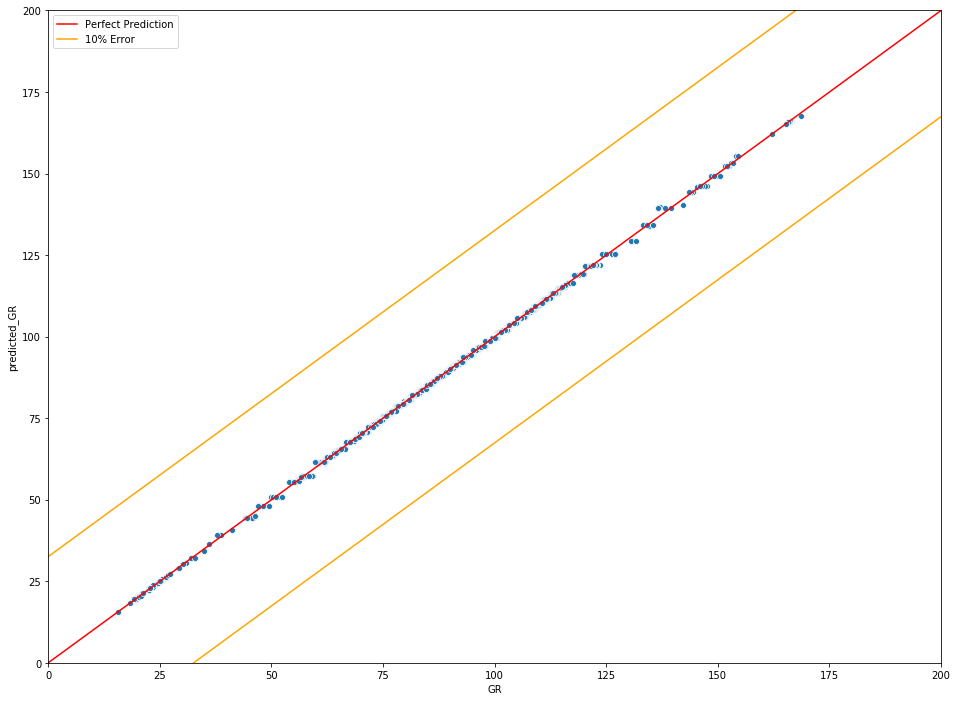

In [64]:
plt.figure(figsize=(16,12))
min_max = np.array([min(tmp_df_new["GR"]), max(tmp_df_new["GR"])])
sns.lineplot(min_max, min_max, label='Perfect Prediction', c='red')
epsilon = 0.1
error_tollorance = min_max[1]*epsilon
sns.lineplot(min_max, min_max-error_tollorance, label='10% Error', c='orange')
sns.lineplot(min_max, min_max+error_tollorance, c='orange')
sns.scatterplot(tmp_df_new["GR"], tmp_df_new["predicted_GR"]);
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.savefig("result_NEUT")